Custom Loss (XGBoost): 369099.99292532954
Mean Squared Error (XGBoost): 40554.44072990832
R-squared (XGBoost): 0.4803549926459194


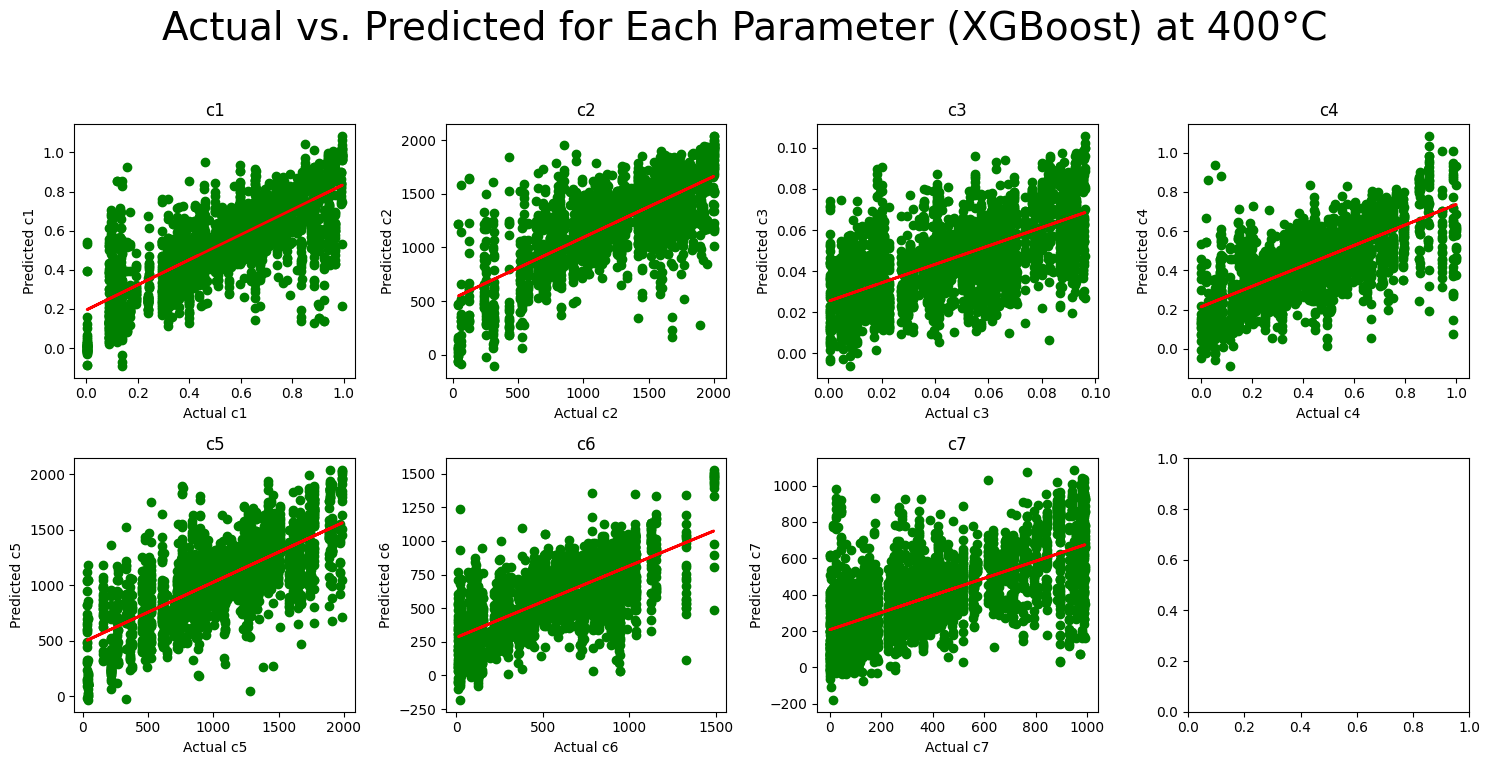

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import xgboost as xgb

X_file_path = 'MODEL_DATA/400C/400c_combined_updated.csv'
y_file_path = 'MODEL_DATA/400C/400c_expanded_hardParam.csv'

X = pd.read_csv(X_file_path)
y = pd.read_csv(y_file_path)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

def custom_loss(y_true, y_pred):
    weights = np.array([1.0, 10, 1.0, 1.0, 10, 10, 5])
    squared_diff = (y_true - y_pred) ** 2
    weighted_squared_diff = squared_diff * weights
    return np.mean(weighted_squared_diff)

params = {
    'objective': 'reg:squarederror', 
    'seed': 42,
}

num_boost_round = 500

xgb_model_custom_loss = xgb.train(params, dtrain, num_boost_round=num_boost_round)

y_pred_xgb_custom_loss = xgb_model_custom_loss.predict(dtest)

custom_loss_value_xgb = custom_loss(y_test.values, y_pred_xgb_custom_loss)
print(f'Custom Loss (XGBoost): {custom_loss_value_xgb}')

mse_xgb = mean_squared_error(y_test, y_pred_xgb_custom_loss)
r2_xgb = r2_score(y_test, y_pred_xgb_custom_loss)
print(f'Mean Squared Error (XGBoost): {mse_xgb}')
print(f'R-squared (XGBoost): {r2_xgb}')

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Actual vs. Predicted for Each Parameter (XGBoost) at 400°C', fontsize=28)

for i, ax in enumerate(axes.flatten()):
    if i < y.shape[1]:
        ax.scatter(y_test.iloc[:, i], y_pred_xgb_custom_loss[:, i], color='green', label='Actual vs. Predicted')

        ax.set(xlabel=f'Actual c{i+1}', ylabel=f'Predicted c{i+1}')
        ax.set_title(f'c{i+1}')

        lr = LinearRegression()
        lr.fit(y_test.iloc[:, i].values.reshape(-1, 1), y_pred_xgb_custom_loss[:, i])
        line = lr.predict(y_test.iloc[:, i].values.reshape(-1, 1))

        ax.plot(y_test.iloc[:, i], line, color='red', linewidth=2, label='Best-fit Line')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
